In [31]:
import random

import pandas as pd
import numpy as np

import os
import json
import sys

import warnings

from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC, LinearSVC

from sklearn.metrics import accuracy_score


warnings.filterwarnings('ignore')  # to suppress some matplotlib deprecation warnings

from sklearn.model_selection import train_test_split, GridSearchCV

from sklearn.neighbors import KNeighborsClassifier

import matplotlib.pyplot as plt

import numpy as np
import json
from keras.applications.mobilenet import preprocess_input
import cv2

#syspath
print(sys.path)
print()
# Any results you write to the current directory are saved as output.

input_path = "/home/shpa9919/scratchDir/doodle/data"
train_simplified_path = input_path + "/train_simplified_small_set/"

train_simplified = os.listdir(train_simplified_path)
number_of_processes = os.cpu_count()
print("Number of processes:", number_of_processes)
BASE_SIZE = 256



Number of processes: 12


Util functions which are used to convert sketch into image of size*size dimention.

In [32]:
def image_generator_xd(dataframe, size, lw=6, time_color=True, ):
    dataframe['drawing'] = dataframe['drawing'].apply(json.loads)
    x = np.zeros((len(dataframe), size * size))
    for i, raw_strokes in enumerate(dataframe.drawing.values):
        x[i, :] = draw_cv2(raw_strokes, size=size, lw=lw, time_color=time_color)
    x = preprocess_input(x).astype(np.float32)
    return x, dataframe['word'].values


def draw_cv2(raw_strokes, size=256, lw=6, time_color=True):
    img = np.zeros((BASE_SIZE, BASE_SIZE), np.uint8)
    for t, stroke in enumerate(raw_strokes):
        for i in range(len(stroke[0]) - 1):
            color = 255 - min(t, 10) * 13 if time_color else 255
            _ = cv2.line(img, (stroke[0][i], stroke[1][i]),
                         (stroke[0][i + 1], stroke[1][i + 1]), color, lw)
    if size != BASE_SIZE:
        return cv2.resize(img, (size, size)).reshape(-1)
    else:
        return img.reshape(-1)
    
    
def get_lambda(value):
    return lambda x: value

Function to prepare the test and training sets.

In [33]:
def read_file(file_name, label, value, rows=100):
    data = pd.read_csv(file_name, index_col='key_id', nrows=rows)
    data['word'] = data['word'].replace(label, value, regex=True)
    return data


# print(train_simplified)
def get_small_sample(dir_listing, sample_size=5, rows=100, random_sample=False):
    sample_files = None
    if random_sample:
        sample_files = random.sample(dir_listing, sample_size)
    else:
        sample_files = dir_listing[:sample_size]

    print("Samples in Account :", sample_files)
    mapping = dict()
    reverse_mapping = dict()

    data_set = []
    for i, sample in enumerate(sample_files):
        print("Reading sample", sample)
        ex_name_raw = sample.split('.')[0]
        ex_name = ex_name_raw.replace(' ', '_')
        mapping[ex_name] = i
        reverse_mapping[i] = ex_name
        data_set.append(read_file(train_simplified_path + sample, ex_name_raw, i, rows))
    return data_set, mapping, reverse_mapping


def split_data(list_data_frames, ts= 0.1):
    training_frames = []
    testing_frames = []
    for df in list_data_frames:
        train_df, test_df = train_test_split(df, test_size=ts, shuffle=False)
        training_frames.append(train_df)
        testing_frames.append(test_df)
    return pd.concat(training_frames), pd.concat(testing_frames)



Prepare the test and training data.

In [34]:
no_of_classes = 20
no_of_rows = 1000

small_data_set, y_mapping, rev_y_mapping = get_small_sample(train_simplified, sample_size=no_of_classes,rows=no_of_rows)
train_set, test_set = split_data(small_data_set, ts = 0.1)

name_to_number = lambda x: y_mapping[x]
number_to_name = lambda x: rev_y_mapping[x]

x_train, y_train = image_generator_xd(train_set, 64)
x_test, y_test = image_generator_xd(test_set, 64)
print("Data prepared")


Samples in Account : ['guitar.csv', 'toilet.csv', 'banana.csv', 'bicycle.csv', 'birthday cake.csv', 'jail.csv', 'The Eiffel Tower.csv', 'camera.csv', 'airplane.csv', 'bird.csv', 'cow.csv', 'windmill.csv', 'cell phone.csv', 'umbrella.csv', 'butterfly.csv', 'fireplace.csv', 'snowflake.csv', 'piano.csv', 'mushroom.csv', 'sailboat.csv']
Reading sample guitar.csv
Reading sample toilet.csv
Reading sample banana.csv
Reading sample bicycle.csv
Reading sample birthday cake.csv
Reading sample jail.csv
Reading sample The Eiffel Tower.csv
Reading sample camera.csv
Reading sample airplane.csv
Reading sample bird.csv
Reading sample cow.csv
Reading sample windmill.csv
Reading sample cell phone.csv
Reading sample umbrella.csv
Reading sample butterfly.csv
Reading sample fireplace.csv
Reading sample snowflake.csv
Reading sample piano.csv
Reading sample mushroom.csv
Reading sample sailboat.csv
Data prepared


The KNN Classifier:

In [35]:
knn = KNeighborsClassifier(n_neighbors = 3, n_jobs=-1)
knn.fit(x_train, y_train)
y_pred_knn = knn.predict(x_test)
print("Accuracy ", accuracy_score(y_test, y_pred_knn))


Accuracy  0.2845


Performing grid search to tune the paramerters:

In [55]:
###############Grid search#######
grid_search_params = {'n_neighbors': np.arange(1,6,1)}

knn = KNeighborsClassifier(n_jobs=-1)
knn = GridSearchCV(knn, grid_search_params, n_jobs=-1) #use all cpu cores
knn.fit(x_train, y_train)
print("Model trained.")


Model trained.


In [59]:
results_knn = pd.DataFrame(knn.cv_results_)
results_knn.sort_values('mean_test_score', ascending = False)


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_neighbors,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score
0,0.788954,0.299817,34.101417,0.517309,1,{'n_neighbors': 1},0.295000,0.276667,0.302500,0.291389,0.010851,1,1.000000,1.000000,1.000000,1.000000,0.000000
2,4.546334,0.236177,39.085834,0.169474,3,{'n_neighbors': 3},0.253333,0.230000,0.260000,0.247778,0.012862,2,0.397500,0.367917,0.392500,0.385972,0.012929
1,3.076169,0.722979,37.889832,0.699052,2,{'n_neighbors': 2},0.240000,0.210833,0.257500,0.236111,0.019249,3,0.435417,0.391667,0.428750,0.418611,0.019246
3,6.261782,0.638803,39.716150,0.101332,4,{'n_neighbors': 4},0.231667,0.212500,0.240000,0.228056,0.011514,4,0.325000,0.283333,0.326667,0.311667,0.020046
4,9.219189,0.764705,29.217169,0.120948,5,{'n_neighbors': 5},0.229167,0.215000,0.239167,0.227778,0.009915,5,0.310417,0.287083,0.302500,0.300000,0.009688


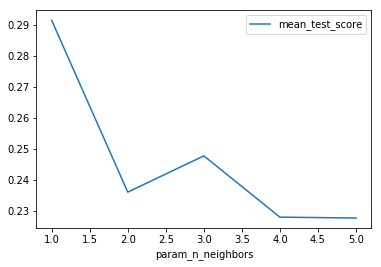

In [57]:
# Plot results of grid search
results_knn.plot('param_n_neighbors','mean_test_score')

In [ ]:
print("---Starting Random Forest----")
# Base RFC model
rfc = RandomForestClassifier(random_state=1)
rfc.fit(x_train, y_train)
print(rfc)
y_pred_rfc = rfc.predict(x_test)
acc_rfc = accuracy_score(y_test, y_pred_rfc)
print('Random forest accuracy: ', acc_rfc)

print("---Finished Random Forest----")

print("SVM with linear kernal")
lsvc = LinearSVC(random_state=1)
lsvc.fit(x_train, y_train)
print(lsvc)
y_pred_lsvc = lsvc.predict(x_test)
acc_lsvc = accuracy_score(y_test, y_pred_lsvc)
print('Linear SVC accuracy: ', acc_lsvc)

print("SVM with RBF Kernal")
svc = SVC(kernel='rbf', random_state=1)
svc.fit(x_train, y_train)
print(svc)
y_pred_svc = svc.predict(x_test)
acc_svc = accuracy_score(y_test, y_pred_svc)
print('Gaussian Radial Basis Function SVC Accuracy: ', acc_svc)